In [4]:
import random
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import learn2learn as l2l
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform, UnetDataTransform_norm, normalize
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


In [5]:
def train(model, batch, optimizer): 
    model.train()
    mse_fct = torch.nn.MSELoss(reduction='sum')

    input_image, target_image, mean, std, fname, slice_num = batch
    train_inputs = input_image.to(device)
    train_targets = target_image.to(device)
    std = std.to(device)
    mean = mean.to(device)

    train_outputs = model(train_inputs)
    train_outputs = train_outputs * std + mean

    loss = mse_fct(train_outputs, train_targets) / torch.sum(torch.abs(train_targets)**2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def evaluate(model, dataloader):
    model.eval()
    total_l1_loss = 0.0
    total_ssim_loss = 0.0
    total_psnr_loss = 0.0
    total_nmse_loss = 0.0
    l1_loss = torch.nn.L1Loss(reduction='sum')
    ssim_fct = SSIMLoss()
    psner_mse_fct = torch.nn.MSELoss(reduction='mean')
    mse_fct = torch.nn.MSELoss(reduction='sum')

    for iter, batch in enumerate(dataloader): 
        input_image, target_image, mean, std, fname, slice_num = batch
        val_inputs = input_image.to(device)
        val_targets = target_image.to(device)
        std = std.to(device)
        mean = mean.to(device)

        val_outputs = model(val_inputs)
        val_outputs = val_outputs * std + mean

        # NMAE
        l1 = l1_loss(val_outputs, val_targets) / torch.sum(torch.abs(val_targets))
        total_l1_loss += l1.item()
        # NMSE 
        nmse_loss = mse_fct(val_outputs, val_targets) / torch.sum(torch.abs(val_targets)**2)
        total_nmse_loss += nmse_loss.item()
        # PSNR
        psnr_loss = 20*torch.log10(torch.tensor(val_targets.max().unsqueeze(0).item()))-10*torch.log10(psner_mse_fct(val_outputs,val_targets))
        total_psnr_loss += psnr_loss.item()
        # SSIM = 1 - loss
        ssim_loss = ssim_fct(val_outputs, val_targets, data_range = val_targets.max().unsqueeze(0))
        total_ssim_loss += (1-ssim_loss.item())

    validation_loss_l1 = total_l1_loss / len(dataloader) 
    validation_loss_NMSE = total_nmse_loss / len(dataloader)
    validation_loss_PSNR = total_psnr_loss / len(dataloader)
    validation_loss_SSIM = total_ssim_loss / len(dataloader)

    return validation_loss_l1, validation_loss_NMSE, validation_loss_PSNR, validation_loss_SSIM


In [6]:
path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXFLAIR_Skyra_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXT1POST_TrioTim_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXFLAIR_Skyra_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXT2_Aera_5-8.yaml'

path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXFLAIR_Skyra_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT1POST_TrioTim_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXFLAIR_Skyra_5-8.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT2_Aera_5-8.yaml'
####################################################################################

# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)


data_transform = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')

adapt_set = SliceDataset(dataset = path_adapt, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                        challenge="multicoil", transform=data_transform, use_dataset_cache=True)
print("Adapt date number: ", len(adapt_set))

test_set = SliceDataset(dataset = path_test, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                      challenge="multicoil", transform=data_transform, use_dataset_cache=True)
print("Validation date number: ", len(test_set))

# dataloader: batch size 1 
adapt_dataloader = torch.utils.data.DataLoader(dataset = adapt_set, batch_size = 1, num_workers = 8, 
                    shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_set, batch_size = 1, num_workers = 8, 
                    shuffle = False, generator = torch.Generator().manual_seed(1))

Adapt date number:  300
Validation date number:  300


In [8]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E6/E6.4/E6.4_standard(NMSE)_T8x200_100epoch/E6.4_standard(NMSE)_T8x200_100epoch_E98_best.pth'
# '/cheng/metaMRI/metaMRI/save/E6.4/E6.4_standard(NMSE)_T8x200_100epoch/E6.4_standard(NMSE)_T8x200_100epoch_E98_best.pth'

model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

##########################
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

adapt_iterator = iter(adapt_dataloader)

test_loss_NMSE_list_standard = []
test_loss_SSIM_list_standard = []

test_loss_l1, test_loss_NMSE, test_loss_PSNR, test_loss_SSIM = evaluate(model, test_dataloader)
print('Iteration:', 0)
print('Testing NMAE', test_loss_l1) 
print('Testing NMSE', test_loss_NMSE) 
print('Testing PSNR', test_loss_PSNR) 
print('Testing SSIM', test_loss_SSIM) 
test_loss_NMSE_list_standard.append(test_loss_NMSE)
test_loss_SSIM_list_standard.append(test_loss_SSIM)


for iteration in range(300):
    print('Iteration:', iteration+1)
    # training
    batch = next(adapt_iterator)
    training_loss = train(model, batch, optimizer)
    print('Adapt NMSE', training_loss) 
    # val
    test_loss_l1, test_loss_NMSE, test_loss_PSNR, test_loss_SSIM = evaluate(model, test_dataloader)
    print('Testing NMAE', test_loss_l1) 
    print('Testing NMSE', test_loss_NMSE) 
    print('Testing PSNR', test_loss_PSNR) 
    print('Testing SSIM', test_loss_SSIM) 
    test_loss_NMSE_list_standard.append(test_loss_NMSE)
    test_loss_SSIM_list_standard.append(test_loss_SSIM)

Iteration: 0
Testing NMAE 0.09876993905752897
Testing NMSE 0.01293691190968578
Testing PSNR 30.375703417460123
Testing SSIM 0.8305979945262273
Iteration: 1
Adapt NMSE 0.010248194448649883
Testing NMAE 0.09809467592587073
Testing NMSE 0.012682834272272885
Testing PSNR 30.463418973286945
Testing SSIM 0.831680040359497
Iteration: 2
Adapt NMSE 0.014112097211182117
Testing NMAE 0.09753678551564614
Testing NMSE 0.01254417518697058
Testing PSNR 30.511105257670085
Testing SSIM 0.8322230045000713
Iteration: 3
Adapt NMSE 0.012363693676888943
Testing NMAE 0.09704825717955828
Testing NMSE 0.012398616642846416
Testing PSNR 30.561326535542808
Testing SSIM 0.8327920150756836
Iteration: 4
Adapt NMSE 0.010620892979204655
Testing NMAE 0.09667693513135116
Testing NMSE 0.012287795779605707
Testing PSNR 30.599752209981283
Testing SSIM 0.833187822898229
Iteration: 5
Adapt NMSE 0.01704241894185543
Testing NMAE 0.09635869727780422
Testing NMSE 0.01217353054244692
Testing PSNR 30.63946127573649
Testing SSIM 0.

In [ ]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E6/E6.3/E6.3_maml(NMSE)_T8x200_1inner_200epoch/E6.3_maml(NMSE)_T8x200_1inner_200epoch_E178_best.pth'

model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

##########################
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

adapt_iterator = iter(adapt_dataloader)

test_loss_NMSE_list_maml = []
test_loss_SSIM_list_maml = []

test_loss_l1, test_loss_NMSE, test_loss_PSNR, test_loss_SSIM = evaluate(model, test_dataloader)
print('Iteration:', 0)
print('Testing NMAE', test_loss_l1) 
print('Testing NMSE', test_loss_NMSE) 
print('Testing PSNR', test_loss_PSNR) 
print('Testing SSIM', test_loss_SSIM) 
test_loss_NMSE_list_maml.append(test_loss_NMSE)
test_loss_SSIM_list_maml.append(test_loss_SSIM)


for iteration in range(300):
    print('Iteration:', iteration+1)
    # training
    batch = next(adapt_iterator)
    training_loss = train(model, batch, optimizer)
    print('Adapt NMSE', training_loss) 
    # val
    test_loss_l1, test_loss_NMSE, test_loss_PSNR, test_loss_SSIM = evaluate(model, test_dataloader)
    print('Testing NMAE', test_loss_l1) 
    print('Testing NMSE', test_loss_NMSE) 
    print('Testing PSNR', test_loss_PSNR) 
    print('Testing SSIM', test_loss_SSIM) 
    test_loss_NMSE_list_maml.append(test_loss_NMSE)
    test_loss_SSIM_list_maml.append(test_loss_SSIM)

Iteration: 0
Testing NMAE 0.14772161423708452
Testing NMSE 0.01776621700970061
Testing PSNR 30.881972428524133
Testing SSIM 0.818286786476771
Iteration: 1
Adapt NMSE 0.017182400450110435
Testing NMAE 0.1409515863228025
Testing NMSE 0.016959637347044365
Testing PSNR 31.0848895853216
Testing SSIM 0.8274754511587548
Iteration: 2
Adapt NMSE 0.01129163894802332
Testing NMAE 0.1349405963538271
Testing NMSE 0.01624606628761147
Testing PSNR 31.272106141755074
Testing SSIM 0.8358067928841619
Iteration: 3
Adapt NMSE 0.01674138568341732
Testing NMAE 0.12932395325465637
Testing NMSE 0.015618590355822535
Testing PSNR 31.44353233684193
Testing SSIM 0.8436211397250494
Iteration: 4
Adapt NMSE 0.013273525051772594
Testing NMAE 0.12448451182607448
Testing NMSE 0.015089185816715613
Testing PSNR 31.593840078874067
Testing SSIM 0.8504031110893596
Iteration: 5
Adapt NMSE 0.01910264417529106
Testing NMAE 0.12033639549080169
Testing NMSE 0.014632788352724729
Testing PSNR 31.726828632932722
Testing SSIM 0.8563

Text(0.5, 1.0, 'Each shot updates only one gradient step')

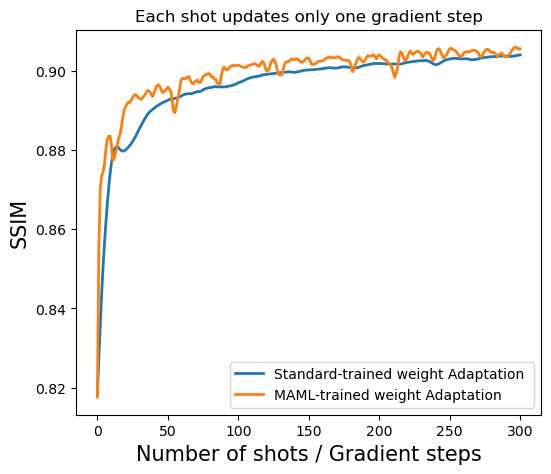

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#plt.figure(figsize=(6,5))
plt.figure(figsize=(6,5))
plt.plot(test_loss_SSIM_list_standard, label='Standard-trained weight Adaptation ', linewidth=2)
plt.plot(test_loss_SSIM_list_maml, label='MAML-trained weight Adaptation', linewidth=2)
# plt.rcParams['font.size'] = 12
plt.legend()
#plt.yticks(np.arange(0, 0.5, 0.1))
plt.xlabel('Number of shots / Gradient steps',fontsize=15)
plt.ylabel('SSIM',fontsize=15)
plt.title('Each shot updates only one gradient step')
# plt.savefig('save/plots/fasterrcnn_v2.png', format='png', bbox_inches='tight')

Text(0.5, 1.0, 'Each shot updates only one gradient step')

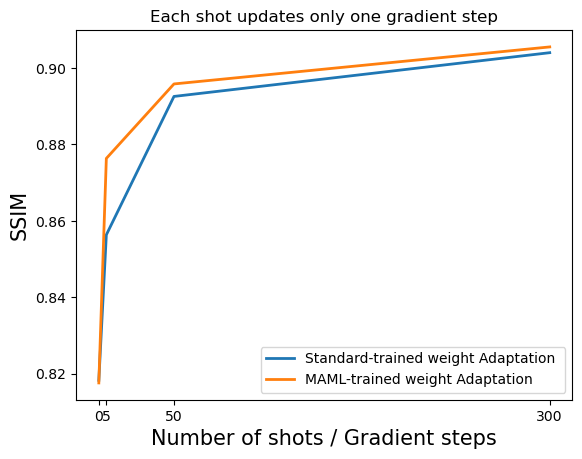

In [ ]:
x = [0,5,50,300]
interested_points_standard = [test_loss_SSIM_list_standard[0], test_loss_SSIM_list_standard[5], test_loss_SSIM_list_standard[50], test_loss_SSIM_list_standard[300]]
interested_points_maml = [test_loss_SSIM_list_maml[0], test_loss_SSIM_list_maml[5], test_loss_SSIM_list_maml[50], test_loss_SSIM_list_maml[300]]
plt.plot(x, interested_points_standard, label='Standard-trained weight Adaptation ', linewidth=2)
plt.plot(x, interested_points_maml, label='MAML-trained weight Adaptation', linewidth=2)
# plt.rcParams['font.size'] = 12
plt.legend()
#plt.yticks(np.arange(0, 0.5, 0.1))
plt.xlabel('Number of shots / Gradient steps',fontsize=15)
plt.xticks(x, x)
plt.ylabel('SSIM',fontsize=15)
plt.title('Each shot updates only one gradient step')